# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [1]:
 # Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [2]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'lr': 5e-4,           # Learning rate.
    'weight_decay': 1e-5, # L2 penalty.
    'num_workers': 3,     # Number of workers on data loader.
    'batch_size': 100,    # Mini-batch size.
    'print_freq': 1,      # Printing frequency.
    'lambda_var': 1.0,    # Variational multiplier in loss.
    'num_gauss': 2,       # Number of gaussians in bottleneck of VAE.
    # 'num_gauss': 20,      # Number of gaussians in bottleneck of VAE.
    'num_samples': 8,     # Number of samples to be generated in evaluation.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


# Carregando o  MNIST

In [3]:
# Root directory for the dataset (to be downloaded).
root = './'

# Transformations over the dataset.
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

# Setting datasets and dataloaders.
train_set = datasets.MNIST(root,
                           train=True,
                           download=True,
                           transform=data_transforms)
test_set = datasets.MNIST(root,
                          train=False,
                          download=False,
                          transform=data_transforms)

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Size of training set: 60000 samples
Size of test set: 10000 samples


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# AutoEncoder Variacional

Idealmente codificações compactas de dados redundantes (i.e. imagens) deveriam produzir representações latentes que fossem independentes uma da outra num nível semântico. Ou seja, cada bin num feature map latente $z$ de um autoencoder deveria codificar o máximo de informação possível (i.e. linhas verticais que compõem um '1', '7' ou '9'; ou círculos que compõem um '6', '8' ou '0') para a reconstrução dos dígitos do MNIST, por exemplo. A [inferência variacional](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf) provém uma forma mais simples de computarmos o Maximum a Posteriori (MAP) de distribuições estatísticas complexas como as que estamos lidando.

![VAE Features](https://www.dropbox.com/s/fkvdn69tkh7tm1p/vae_gaussian.png?dl=1)

Se tivermos controle sobre representações latentes em $z$ que codificam features de algo nível semântico, podemos utilizar o Decoder de um AE para geração de novas amostras. Usando o Encoder de um AE tradicional, conseguimos partir do vetor de entrada $x$ e chegar no vetor latente $z \sim q(z ∣ x)$. Porém, como não temos controle sobre a distribuição $q$, não é possível fazer o caminho inverso, ou seja, a partir de $z$ modelar $x \sim p(x | z)$. Essa é a motivação para um Variational AutoEncoder (VAE).

![VAE x->z](https://www.dropbox.com/s/o8daaskdrhfav7r/VAE_Enc.png?dl=1)

![VAE z->x](https://www.dropbox.com/s/wqi8nsak84i11mi/VAE_Dec.png?dl=1)

Para podermos ter um controle maior sobre distribuição de cada bin de $z$, adicionamos uma "regularização" $\mathcal{L}_{KL}(\mu, \sigma)$ à loss de regressão $\mathcal{L}_{r}(x, \hat{x})$ de um AE tradicional. Percebe-se que $\mu$ e $\sigma$ devem codificar a média e o desvio padrão de distribuições gaussianas multivariadas, o que permite realizarmos uma amostragem dessa distribuição. Não podemos, porém, backpropagar de nós na nossa rede que realizem amostragem de uma distribuição. Portanto, precisamos do truque da reparametrização mostrado abaixo para backpropagarmos apenas por $\mu$ e $\sigma$, mas não por $\epsilon$.

![Reparametrization](https://jaan.io/images/reparametrization.png)

Assim, a arquitetura final de um VAE segue o esquema a seguir composto no bottleneck por um vetor $\mu$, um vetor $\sigma$ e um vetor $\epsilon$, que formam a representação latente $z = \mu + \sigma * \epsilon$.

![VAE training](https://www.dropbox.com/s/719vkfnfsobimmd/VAE_training.png?dl=1)

A ideia é que cada gaussiana codifique uma característica de alto nível nos dados, permitindo que utilizemos o modelo generativo do VAE para, de fato, gerar amostras novas verossímeis no domínio dos dados de treino.

![VAE gif](https://media.giphy.com/media/26ufgj5LH3YKO1Zlu/giphy.gif)

Para entender mais sobre "disentangled representations", ler o paper original do [VAE](https://arxiv.org/abs/1312.6114), o [$\beta$-VAE](https://openreview.net/references/pdf?id=Sy2fzU9gl) e o paper que propõe as [InfoGANs](https://arxiv.org/pdf/1606.03657.pdf):

# Demo: Síntese de imagens usando um VAE.

1.   Definindo a arquitetura do VAE. O Encoder da rede é composto de duas camadas precedendo as camadas $\mu$ e $\sigma$, de forma que $\mu$ e $\sigma$ recebam as mesmas entradas e se combinem como explicado a cima para formar o vetor latente $z$. A dimensionalidade de entrada dos dados ($784$, no caso do MNIST) é diminuída gradativamente até chegar no bottleneck da rede, assim como no AE linear. Ambas camadas $\mu$ e $\sigma$ recebem dados de dimensionalidade alta e os codificam para uma saída dada pela variável `n_gaus`. Não é preciso criar uma camada explícita para $\epsilon$, já que ele só representa a amostragem de uma distribuição gaussiana ([torch.randn()](https://pytorch.org/docs/stable/torch.html#torch.randn));
2.   A implementação divide o `forward()` nos métodos `encode()`, que encapsula o forward pelo Encoder; `reparameterize()`, que amostra $\epsilon$ e realiza o truque da reparametrização; e `decode()`, que faz o forward de $z$ pelo Decoder da rede;
3.   Define-se a loss composta do VAE na função `variational_loss()`, com os componentes de reconstrução ($\mathcal{L}_{rec}$, usando a BCE) e o componente variacional ($\mathcal{L}_{KL}$). Ver o Apêndice B do paper dos [VAEs](https://arxiv.org/pdf/1312.6114.pdf) para a fórmula de $\mathcal{L}_{KL}$;
4.   Na função `generate_2d()` pode-se alterar manualmente as dimensões da tupla `dim_linspace` do vetor latente até se achar duas dimensões que codifiquem propriedades semânticas das imagens sintetizadas.

# Definindo a arquitetura

In [4]:
# AutoEncoder implementation.
class VariationalAutoEncoder(nn.Module):
    
    def __init__(self, n_gaus):

        super(VariationalAutoEncoder, self).__init__()
        
        self.n_gaus = n_gaus
        
        # Encoder.
        self.enc_1 = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
        )
        self.enc_2 = nn.Sequential(
            nn.Linear(400, 200),
            nn.ReLU(),
        )
        # Layers mu and sigma.
        self.enc_mu = nn.Linear(200, n_gaus) # Mean vector.
        self.enc_sigma = nn.Linear(200, n_gaus) # Std vector.
        
        # Decoder.
        self.decoder = nn.Sequential(
            nn.Linear(n_gaus, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )
        
        self.initialize_weights()
        
    # Encoding function.
    def encode(self, x):
        
        out_1 = self.enc_1(x)
        out_2 = self.enc_2(out_1)
        
        out_mu = self.enc_mu(out_2) # Mean vector.
        out_sigma = self.enc_sigma(out_2) # Std vector.
        
        return out_mu, out_sigma
        
    # Decoding function.
    def decode(self, z):
        
        out = self.decoder(z)
        
        return out
               
    # Reparametrization function. 
    def reparameterize(self, mu, logvar):
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + (eps * std)
    
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        
        mu, logvar = self.encode(x)
        
        z = self.reparameterize(mu, logvar)
        
        dec = self.decode(z)
        
        return dec, mu, logvar

# Instantiating architecture.
net = VariationalAutoEncoder(args['num_gauss']).to(args['device'])

# Printing architecture.
print(net)

VariationalAutoEncoder(
  (enc_1): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (enc_2): Sequential(
    (0): Linear(in_features=400, out_features=200, bias=True)
    (1): ReLU()
  )
  (enc_mu): Linear(in_features=200, out_features=2, bias=True)
  (enc_sigma): Linear(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


# Definindo o otimizador

In [5]:
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'])

# Definindo a loss

In [6]:
# Reconstruction + KL losses summed over all elements and batch.
def variational_loss(recon_x, x, mu, logvar):
    
    # Reconstruction loss using BCE
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence loss.
    # See Appendix B from VAE paper:
    #     https://arxiv.org/pdf/1312.6114.pdf.
    # See Pytorch's implementation of VAEs:
    #     https://github.com/pytorch/examples/blob/master/vae/main.py.
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE, KLD

# Criando funções para Treino e Teste

In [7]:
# Training procedure.
def train(train_loader, net, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data
        
        # Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])
        
        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs, mu, logvar = net(inps)

        # Computing total loss.
        loss_bce, loss_kld = variational_loss(outs, inps, mu, logvar)
        
        loss = loss_bce + args['lambda_var'] * loss_kld

        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Updating lists.
        train_loss.append((loss_bce.data.item(),
                           args['lambda_var'] * loss_kld.data.item(),
                           loss.data.item()))
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train bce loss %.4f +/- %.4f], [train kld loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss[:,0].mean(), train_loss[:,0].std(), train_loss[:,1].mean(), train_loss[:,1].std(), (toc - tic)))
    print('-------------------------------------------------------------------')
    

In [8]:
# Testing procedure.
def test(test_loader, net, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images and labels for batch.
        inps, labs = batch_data

        # Casting to cuda variables and reshaping.
        inps = inps.view(inps.size(0), -1).to(args['device'])

        # Forwarding.
        outs, mu, logvar = net(inps)

        # Computing loss.
        loss_bce, loss_kld = variational_loss(outs, inps, mu, logvar)
        
        loss = loss_bce + args['lambda_var'] * loss_kld
        
        # Updating lists.
        test_loss.append((loss_bce.data.item(),
                          args['lambda_var'] * loss_kld.data.item(),
                          loss.data.item()))
        
        if i == 0 and epoch % args['print_freq'] == 0:
            
            fig, ax = plt.subplots(2, 8, figsize=(16, 4))
        
        if i < 8 and epoch % args['print_freq'] == 0:
            
            ax[0, i].imshow(inps.view(inps.size(0), 28, 28)[0].detach().cpu().numpy())
            ax[0, i].set_yticks([])
            ax[0, i].set_xticks([])
            ax[0, i].set_title('Image ' + str(i + 1))
            
            ax[1, i].imshow(outs.view(inps.size(0), 28, 28)[0].detach().cpu().numpy())
            ax[1, i].set_yticks([])
            ax[1, i].set_xticks([])
            ax[1, i].set_title('Reconstructed ' + str(i + 1))
            
        if i == 8 and epoch % args['print_freq'] == 0:
            
            plt.show()
    
    toc = time.time()
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test bce loss %.4f +/- %.4f], [test kld loss %.4f +/- %.4f], [testing time %.2f]' % (
        epoch, test_loss[:,0].mean(), test_loss[:,0].std(), test_loss[:,1].mean(), test_loss[:,1].std(), (toc - tic)))
    print('-------------------------------------------------------------------')

In [9]:
# Evaluation procedure for sample generation.
def evaluate(net, n_samples, n_gauss):

    # Setting network for evaluation mode.
    net.eval()
    
    # Plotting new samples generated from VAE.
    fig, ax = plt.subplots(1, n_samples, figsize=(n_samples*2, 2))

    # Iterating over batches.
    for i in range(n_samples):
        
        # Sampling from Gaussian.
        sample = torch.randn(1, n_gauss).to(args['device'])
        
        # Forwarding through Decoder.
        sample = net.decode(sample).detach().cpu().view(28, 28).numpy()
        
        ax[i].imshow(sample)
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_title('New Sample ' + str(i + 1))
        
    plt.show()

# Iterando sobre epochs

-------------------------------------------------------------------
[epoch 1], [train bce loss 21227.2110 +/- 6892.4402], [train kld loss 304.5895 +/- 386.1213], [training time 11.97]
-------------------------------------------------------------------


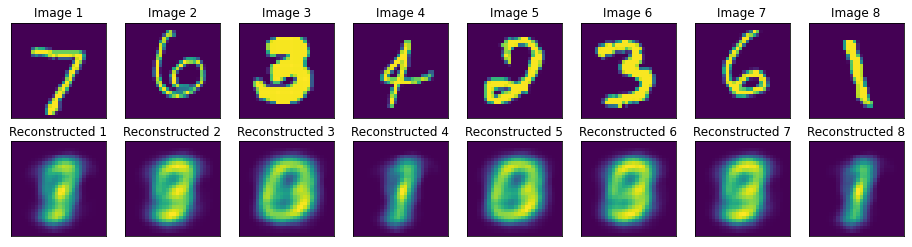

-------------------------------------------------------------------
[epoch 1], [test bce loss 18843.9005 +/- 1034.8980], [test kld loss 229.4608 +/- 34.8749], [testing time 2.98]
-------------------------------------------------------------------


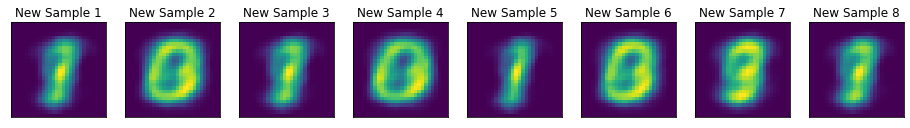

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train bce loss 18779.7460 +/- 490.0847], [train kld loss 227.3676 +/- 15.1910], [training time 9.06]
-------------------------------------------------------------------


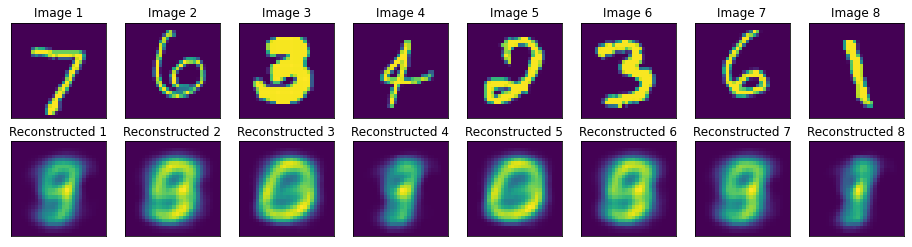

-------------------------------------------------------------------
[epoch 2], [test bce loss 18547.1125 +/- 1009.9963], [test kld loss 243.2073 +/- 36.9218], [testing time 1.64]
-------------------------------------------------------------------


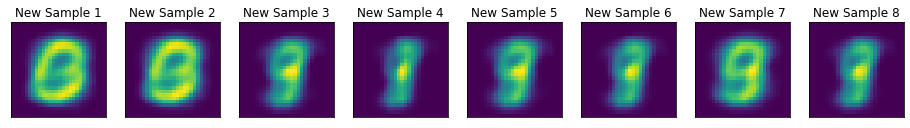

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 3], [train bce loss 17748.8981 +/- 747.2604], [train kld loss 358.0632 +/- 74.1189], [training time 8.06]
-------------------------------------------------------------------


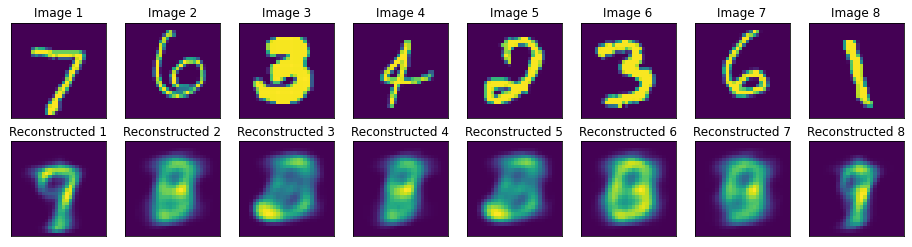

-------------------------------------------------------------------
[epoch 3], [test bce loss 17087.2718 +/- 924.8373], [test kld loss 429.7442 +/- 50.7018], [testing time 1.77]
-------------------------------------------------------------------


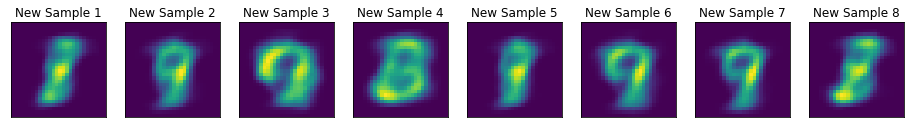

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 4], [train bce loss 16799.2555 +/- 552.7607], [train kld loss 449.6734 +/- 24.4727], [training time 8.00]
-------------------------------------------------------------------


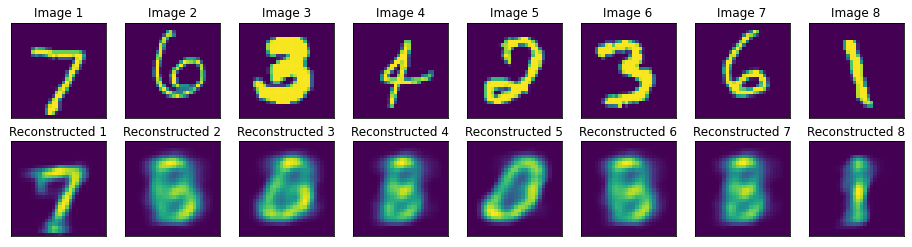

-------------------------------------------------------------------
[epoch 4], [test bce loss 16428.2605 +/- 881.9184], [test kld loss 463.2746 +/- 45.3577], [testing time 1.69]
-------------------------------------------------------------------


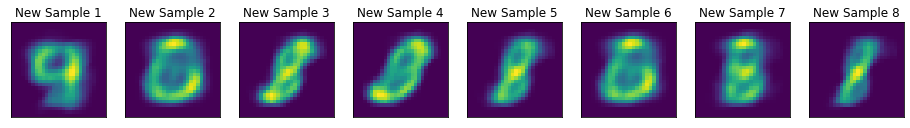

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 5], [train bce loss 16173.4074 +/- 540.6403], [train kld loss 478.0978 +/- 19.4267], [training time 8.49]
-------------------------------------------------------------------


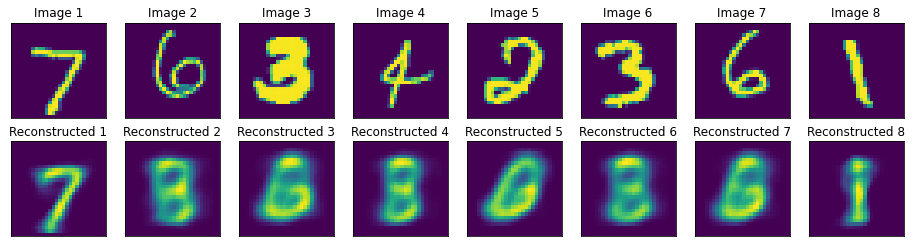

-------------------------------------------------------------------
[epoch 5], [test bce loss 16038.8379 +/- 862.3379], [test kld loss 456.0270 +/- 35.3291], [testing time 2.12]
-------------------------------------------------------------------


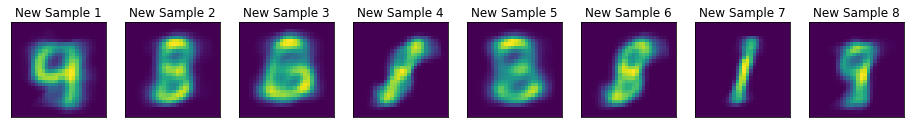

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 6], [train bce loss 15766.8607 +/- 510.3791], [train kld loss 499.5421 +/- 19.0840], [training time 8.06]
-------------------------------------------------------------------


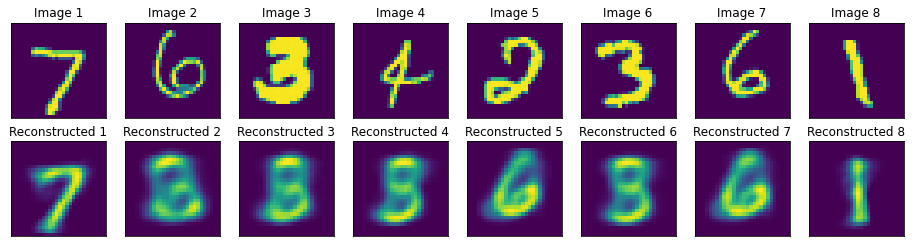

-------------------------------------------------------------------
[epoch 6], [test bce loss 15628.4874 +/- 838.7426], [test kld loss 499.2235 +/- 26.9816], [testing time 1.69]
-------------------------------------------------------------------


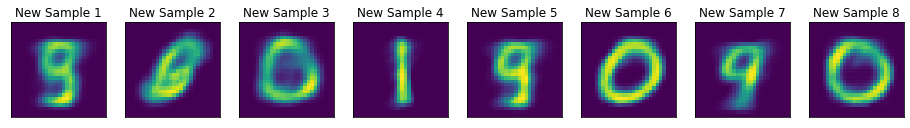

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 7], [train bce loss 15420.5453 +/- 506.3616], [train kld loss 521.9353 +/- 19.7034], [training time 7.93]
-------------------------------------------------------------------


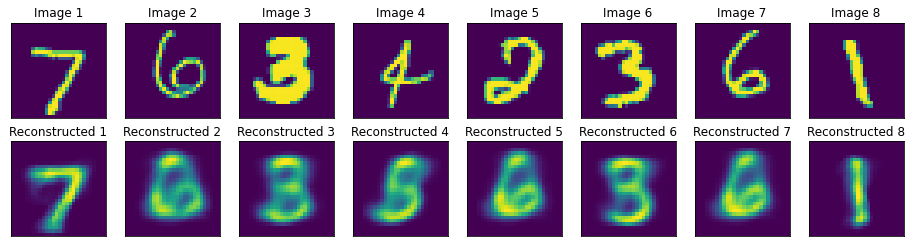

-------------------------------------------------------------------
[epoch 7], [test bce loss 15317.2543 +/- 848.3018], [test kld loss 513.3550 +/- 29.7844], [testing time 1.69]
-------------------------------------------------------------------


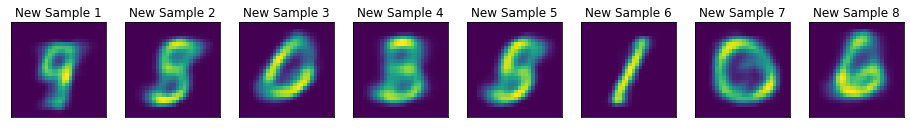

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 8], [train bce loss 15124.2403 +/- 503.7538], [train kld loss 542.5396 +/- 15.8705], [training time 8.76]
-------------------------------------------------------------------


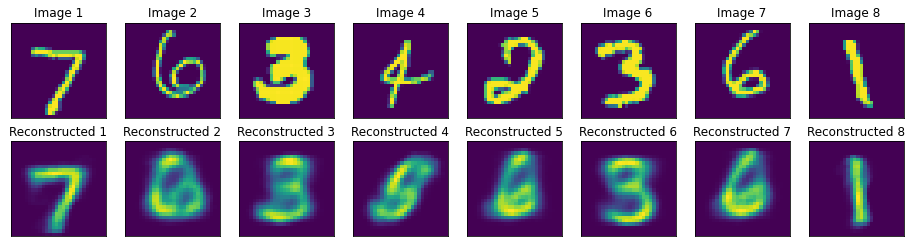

-------------------------------------------------------------------
[epoch 8], [test bce loss 15029.6604 +/- 852.0098], [test kld loss 555.2281 +/- 24.9258], [testing time 1.64]
-------------------------------------------------------------------


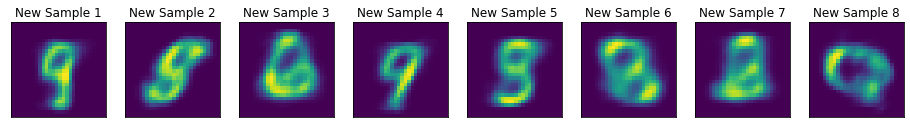

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 9], [train bce loss 14899.4635 +/- 472.2163], [train kld loss 556.1296 +/- 15.3301], [training time 8.04]
-------------------------------------------------------------------


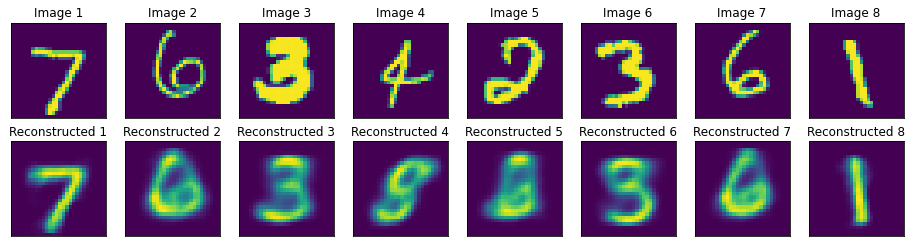

-------------------------------------------------------------------
[epoch 9], [test bce loss 14795.1449 +/- 787.0194], [test kld loss 570.0582 +/- 22.4406], [testing time 1.70]
-------------------------------------------------------------------


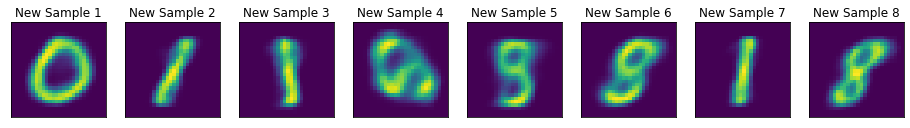

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 10], [train bce loss 14719.4928 +/- 505.9256], [train kld loss 569.6684 +/- 15.5638], [training time 8.04]
-------------------------------------------------------------------


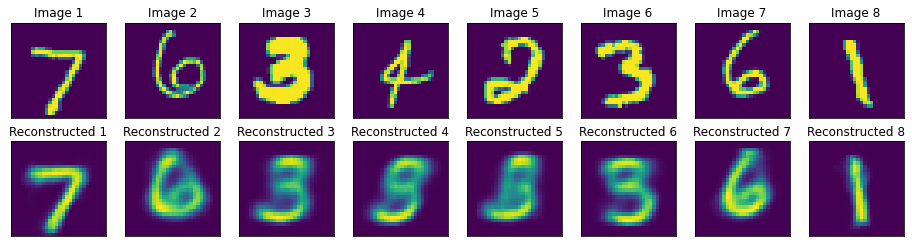

-------------------------------------------------------------------
[epoch 10], [test bce loss 14659.3746 +/- 815.0128], [test kld loss 576.4856 +/- 24.6644], [testing time 1.76]
-------------------------------------------------------------------


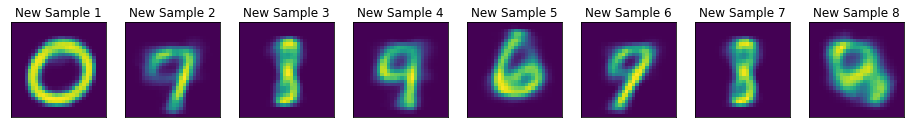

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 11], [train bce loss 14571.2110 +/- 507.1001], [train kld loss 578.7911 +/- 14.2581], [training time 8.02]
-------------------------------------------------------------------


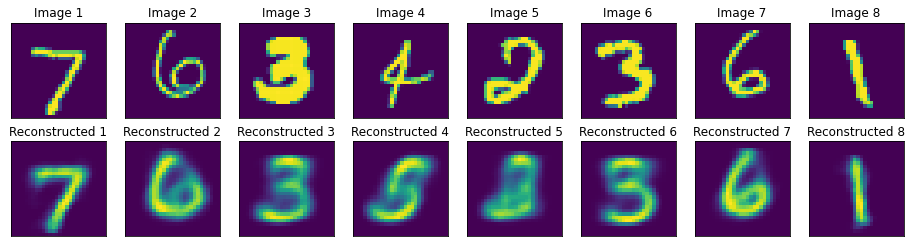

-------------------------------------------------------------------
[epoch 11], [test bce loss 14543.0812 +/- 817.8993], [test kld loss 579.1810 +/- 23.7877], [testing time 1.63]
-------------------------------------------------------------------


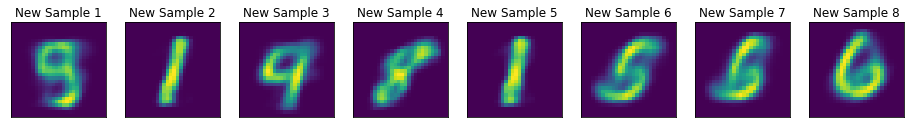

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 12], [train bce loss 14445.6121 +/- 509.4434], [train kld loss 587.4837 +/- 14.5348], [training time 8.07]
-------------------------------------------------------------------


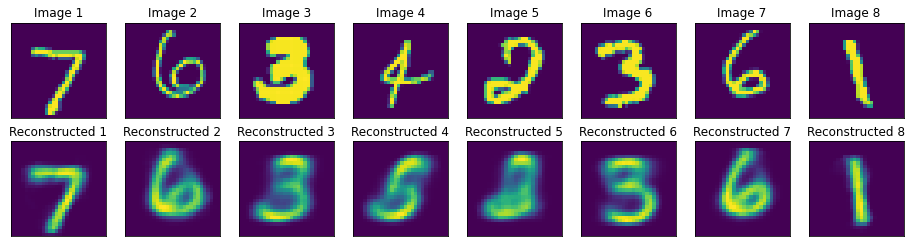

-------------------------------------------------------------------
[epoch 12], [test bce loss 14419.3920 +/- 780.9035], [test kld loss 595.7829 +/- 20.8743], [testing time 1.79]
-------------------------------------------------------------------


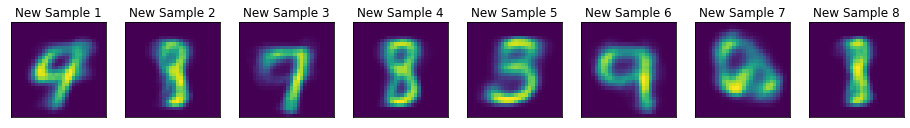

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 13], [train bce loss 14347.8861 +/- 472.8381], [train kld loss 593.9977 +/- 14.2420], [training time 8.10]
-------------------------------------------------------------------


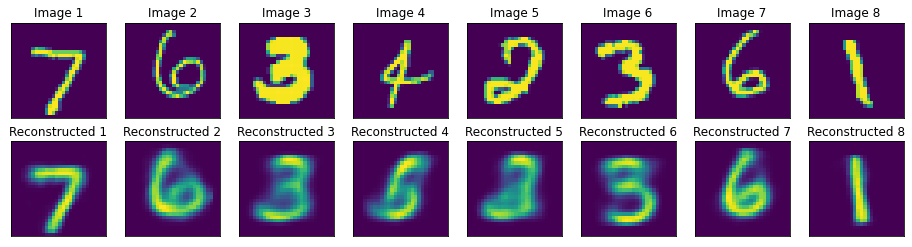

-------------------------------------------------------------------
[epoch 13], [test bce loss 14349.0014 +/- 814.0371], [test kld loss 587.0333 +/- 23.7506], [testing time 1.72]
-------------------------------------------------------------------


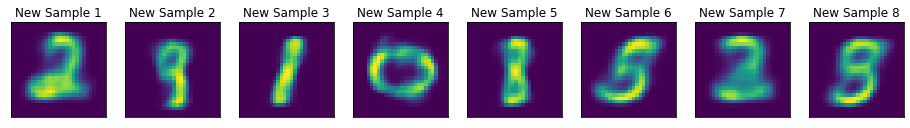

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 14], [train bce loss 14253.3740 +/- 477.8195], [train kld loss 599.3993 +/- 13.2805], [training time 8.19]
-------------------------------------------------------------------


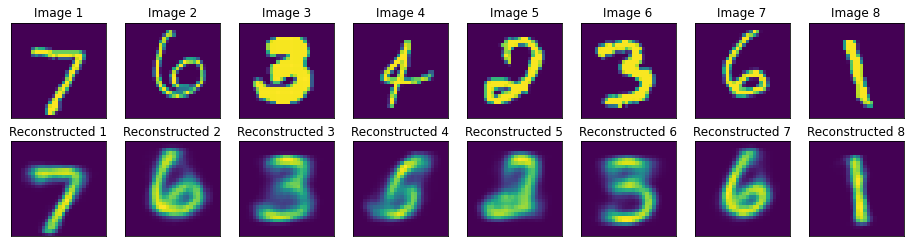

-------------------------------------------------------------------
[epoch 14], [test bce loss 14254.5273 +/- 839.3325], [test kld loss 615.4417 +/- 21.2108], [testing time 1.87]
-------------------------------------------------------------------


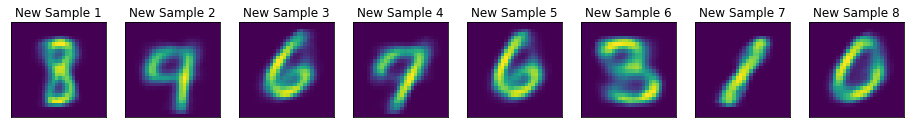

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 15], [train bce loss 14171.2466 +/- 518.6989], [train kld loss 602.9658 +/- 13.5193], [training time 8.08]
-------------------------------------------------------------------


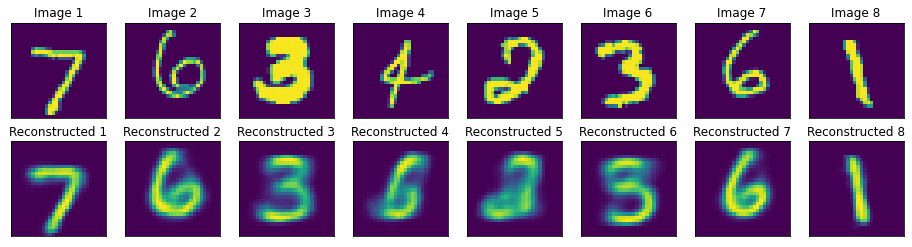

-------------------------------------------------------------------
[epoch 15], [test bce loss 14213.9211 +/- 792.1722], [test kld loss 596.0199 +/- 22.8472], [testing time 1.67]
-------------------------------------------------------------------


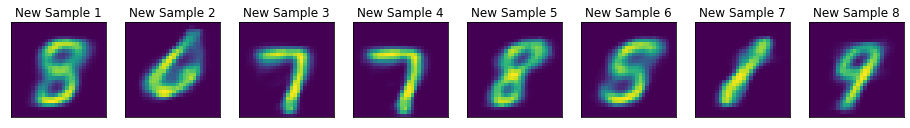

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 16], [train bce loss 14110.4195 +/- 465.5838], [train kld loss 608.7409 +/- 13.6543], [training time 8.64]
-------------------------------------------------------------------


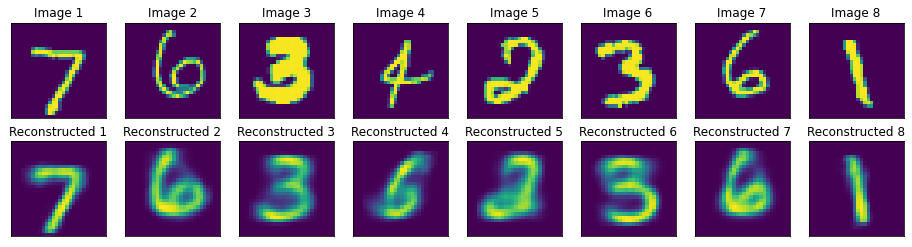

-------------------------------------------------------------------
[epoch 16], [test bce loss 14138.2084 +/- 790.9327], [test kld loss 604.1311 +/- 22.9910], [testing time 1.70]
-------------------------------------------------------------------


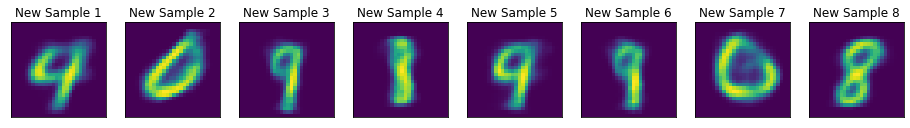

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 17], [train bce loss 14046.1190 +/- 475.9943], [train kld loss 613.7134 +/- 13.0336], [training time 8.02]
-------------------------------------------------------------------


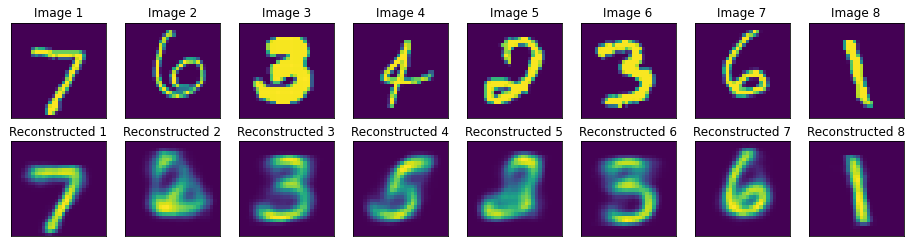

-------------------------------------------------------------------
[epoch 17], [test bce loss 14078.0382 +/- 810.1657], [test kld loss 613.0146 +/- 27.8073], [testing time 1.63]
-------------------------------------------------------------------


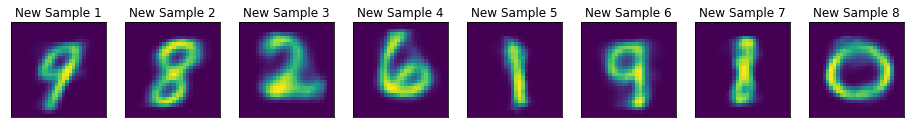

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 18], [train bce loss 13988.3678 +/- 502.9187], [train kld loss 617.3432 +/- 15.1379], [training time 8.01]
-------------------------------------------------------------------


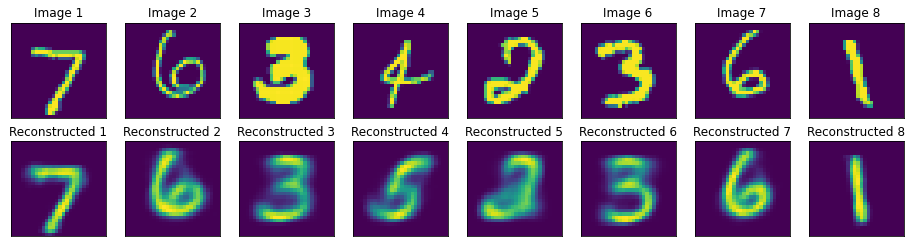

-------------------------------------------------------------------
[epoch 18], [test bce loss 14075.9704 +/- 841.9479], [test kld loss 602.4707 +/- 21.1495], [testing time 1.63]
-------------------------------------------------------------------


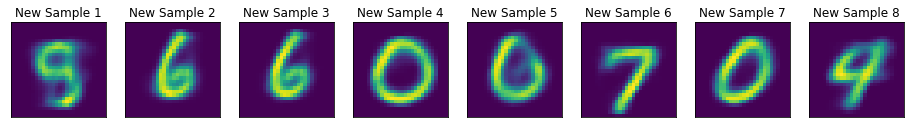

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 19], [train bce loss 13926.4035 +/- 510.1344], [train kld loss 619.8831 +/- 13.9391], [training time 7.99]
-------------------------------------------------------------------


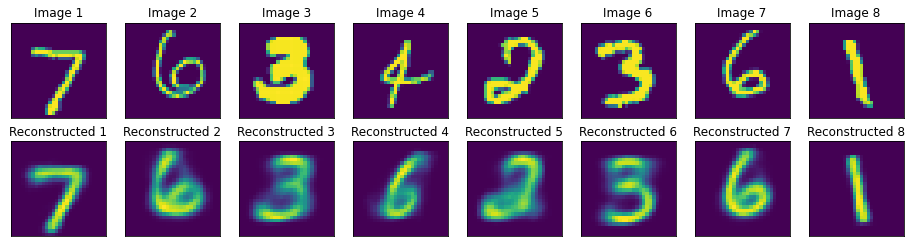

-------------------------------------------------------------------
[epoch 19], [test bce loss 13990.2387 +/- 820.7209], [test kld loss 600.6414 +/- 24.7598], [testing time 1.68]
-------------------------------------------------------------------


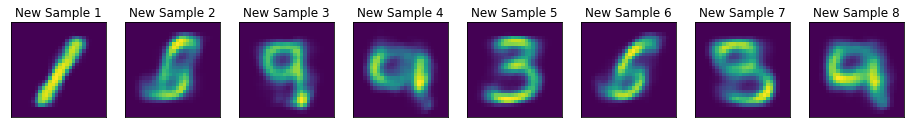

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 20], [train bce loss 13879.3010 +/- 490.0116], [train kld loss 622.6742 +/- 14.5164], [training time 8.07]
-------------------------------------------------------------------


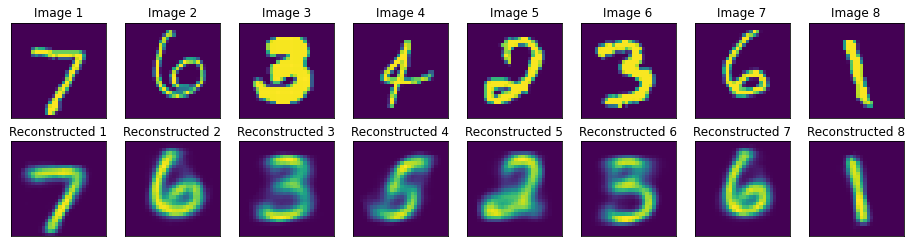

-------------------------------------------------------------------
[epoch 20], [test bce loss 13961.0678 +/- 821.3360], [test kld loss 613.2186 +/- 18.4557], [testing time 1.69]
-------------------------------------------------------------------


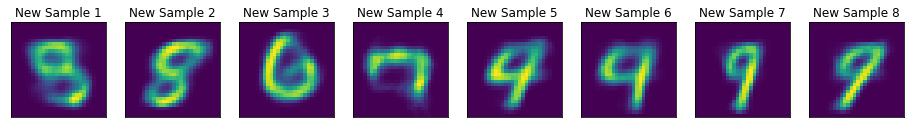

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 21], [train bce loss 13841.2407 +/- 497.2532], [train kld loss 624.6459 +/- 13.2543], [training time 7.97]
-------------------------------------------------------------------


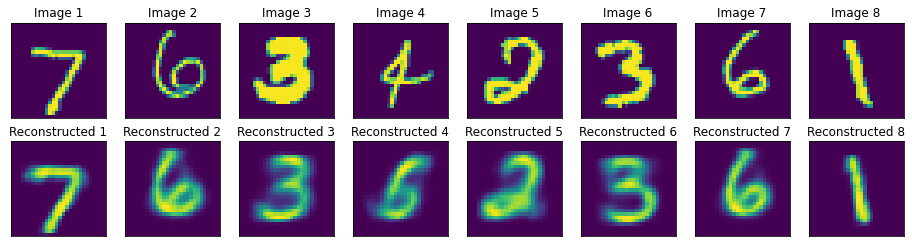

-------------------------------------------------------------------
[epoch 21], [test bce loss 13895.6876 +/- 808.9701], [test kld loss 616.8997 +/- 21.5755], [testing time 1.78]
-------------------------------------------------------------------


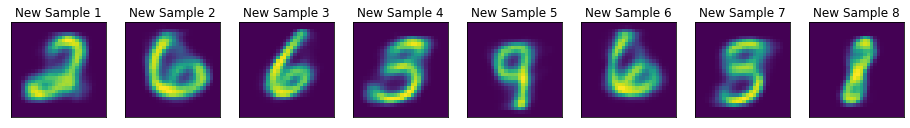

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 22], [train bce loss 13790.4347 +/- 473.2489], [train kld loss 630.0686 +/- 13.2455], [training time 8.06]
-------------------------------------------------------------------


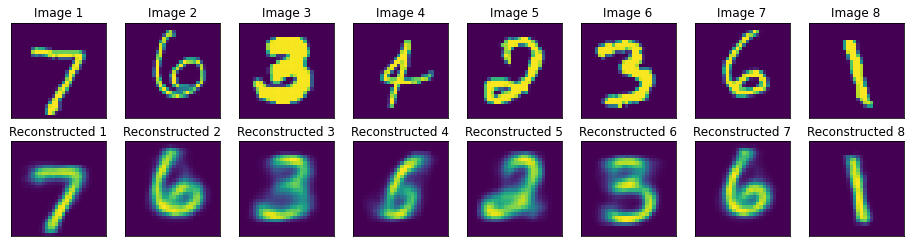

-------------------------------------------------------------------
[epoch 22], [test bce loss 13893.7891 +/- 833.9922], [test kld loss 616.4932 +/- 22.0459], [testing time 1.71]
-------------------------------------------------------------------


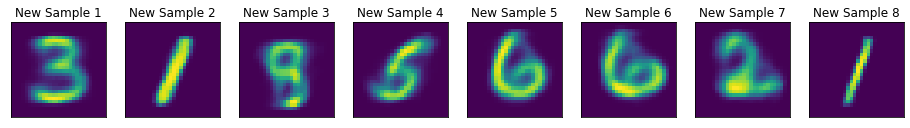

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 23], [train bce loss 13763.6578 +/- 456.2780], [train kld loss 630.5220 +/- 13.0679], [training time 8.06]
-------------------------------------------------------------------


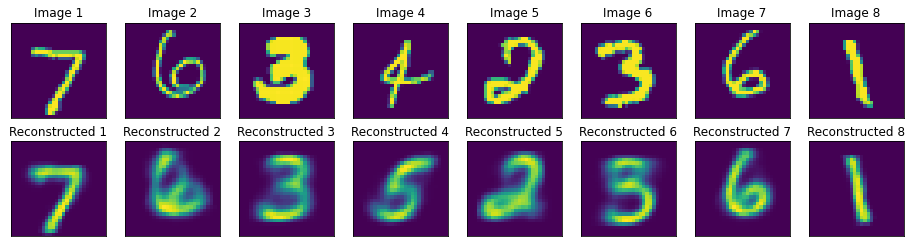

-------------------------------------------------------------------
[epoch 23], [test bce loss 13812.1842 +/- 826.3790], [test kld loss 634.4336 +/- 20.6504], [testing time 1.77]
-------------------------------------------------------------------


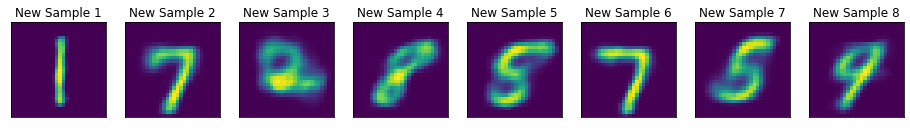

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 24], [train bce loss 13718.2478 +/- 487.7111], [train kld loss 632.9848 +/- 13.9954], [training time 8.03]
-------------------------------------------------------------------


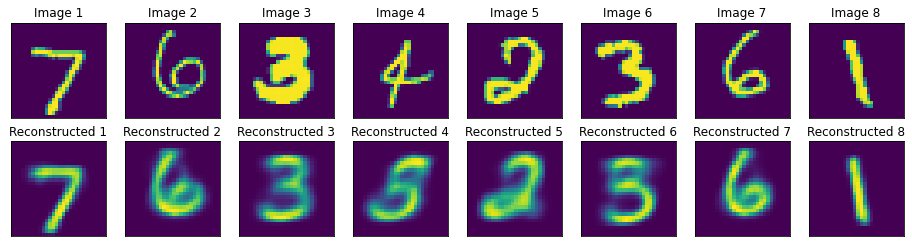

-------------------------------------------------------------------
[epoch 24], [test bce loss 13807.0823 +/- 846.6738], [test kld loss 628.2369 +/- 20.7109], [testing time 1.65]
-------------------------------------------------------------------


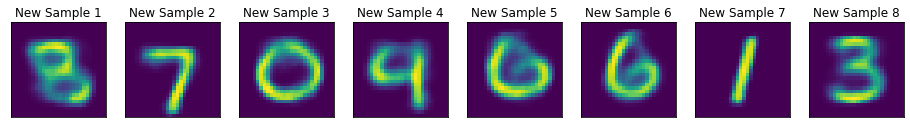

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 25], [train bce loss 13691.4361 +/- 474.2398], [train kld loss 635.7916 +/- 13.0292], [training time 7.98]
-------------------------------------------------------------------


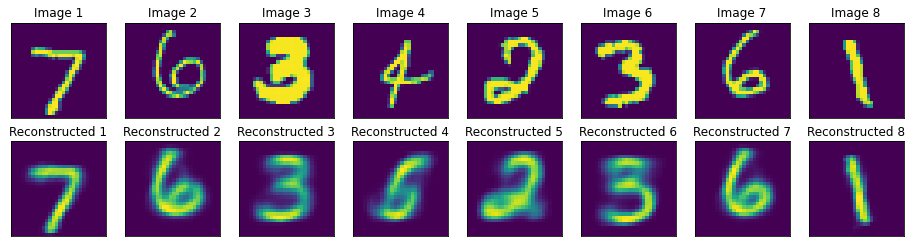

-------------------------------------------------------------------
[epoch 25], [test bce loss 13797.9683 +/- 836.2757], [test kld loss 637.6924 +/- 19.4644], [testing time 1.85]
-------------------------------------------------------------------


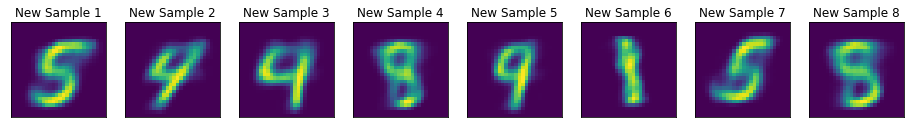

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 26], [train bce loss 13651.3105 +/- 453.0337], [train kld loss 638.4043 +/- 12.3973], [training time 8.00]
-------------------------------------------------------------------


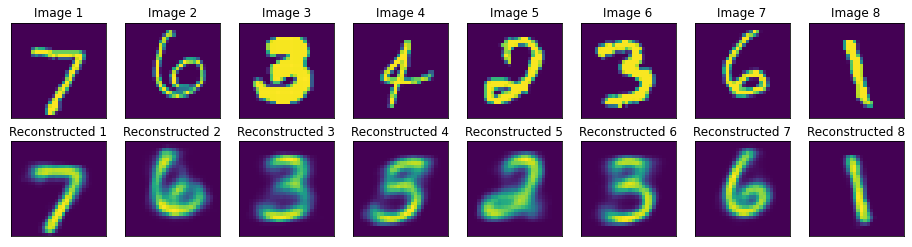

-------------------------------------------------------------------
[epoch 26], [test bce loss 13744.3594 +/- 793.7644], [test kld loss 632.2717 +/- 21.2413], [testing time 1.64]
-------------------------------------------------------------------


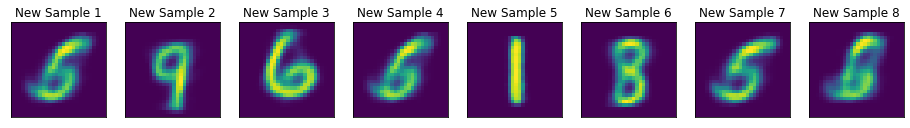

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 27], [train bce loss 13629.6385 +/- 459.8156], [train kld loss 638.6908 +/- 12.1202], [training time 8.13]
-------------------------------------------------------------------


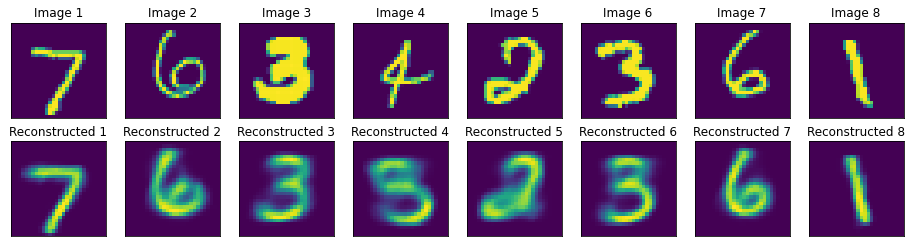

-------------------------------------------------------------------
[epoch 27], [test bce loss 13767.3556 +/- 820.1701], [test kld loss 637.7612 +/- 20.3181], [testing time 1.91]
-------------------------------------------------------------------


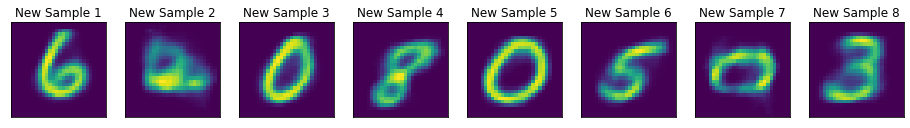

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 28], [train bce loss 13587.6792 +/- 486.0287], [train kld loss 639.8897 +/- 12.9664], [training time 8.10]
-------------------------------------------------------------------


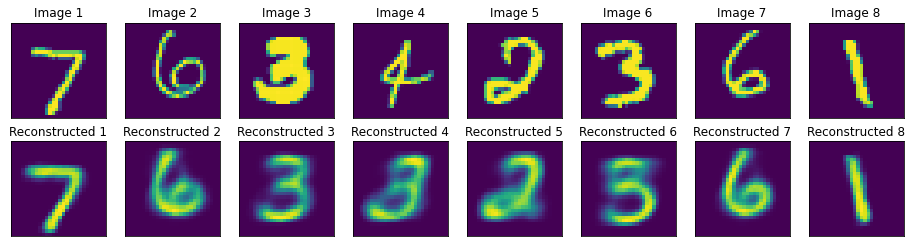

-------------------------------------------------------------------
[epoch 28], [test bce loss 13751.5491 +/- 817.3633], [test kld loss 626.1679 +/- 19.7888], [testing time 1.75]
-------------------------------------------------------------------


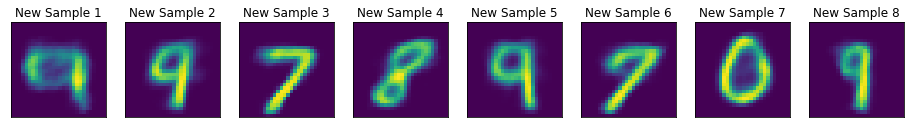

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 29], [train bce loss 13566.9369 +/- 473.7102], [train kld loss 642.3751 +/- 12.3120], [training time 8.07]
-------------------------------------------------------------------


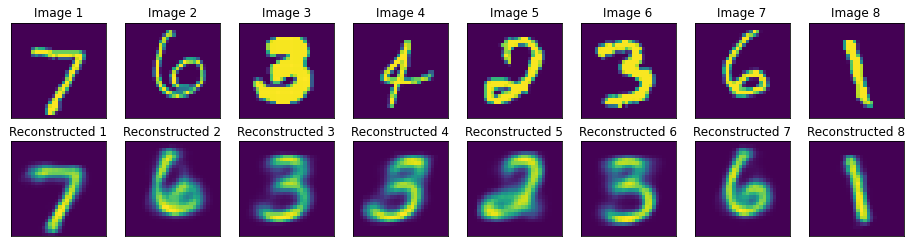

-------------------------------------------------------------------
[epoch 29], [test bce loss 13692.6986 +/- 845.6629], [test kld loss 649.3955 +/- 24.7024], [testing time 1.68]
-------------------------------------------------------------------


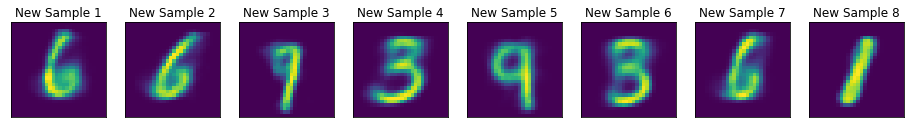

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 30], [train bce loss 13534.5088 +/- 456.1549], [train kld loss 645.0194 +/- 14.5704], [training time 8.04]
-------------------------------------------------------------------


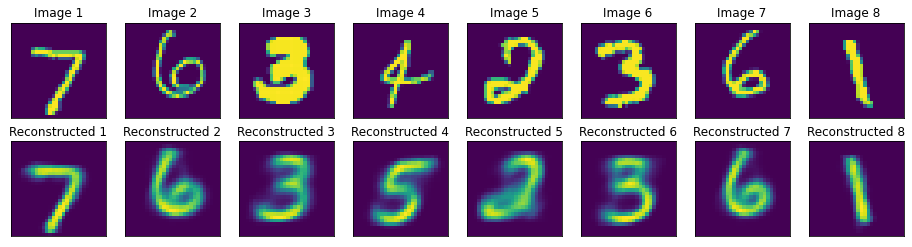

-------------------------------------------------------------------
[epoch 30], [test bce loss 13654.8992 +/- 838.9204], [test kld loss 642.2531 +/- 22.9425], [testing time 1.69]
-------------------------------------------------------------------


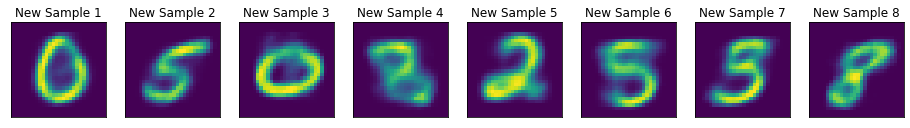

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 31], [train bce loss 13509.2462 +/- 461.7334], [train kld loss 644.8883 +/- 12.2824], [training time 8.03]
-------------------------------------------------------------------


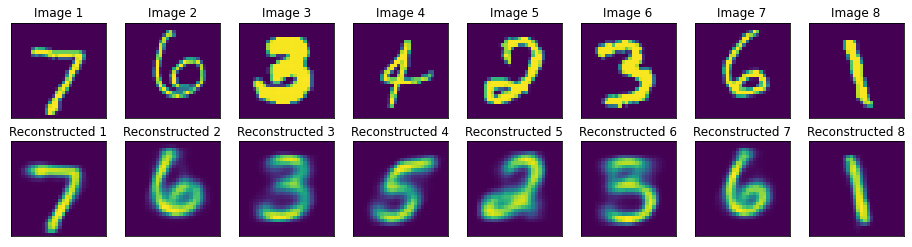

-------------------------------------------------------------------
[epoch 31], [test bce loss 13646.6703 +/- 828.8156], [test kld loss 645.7939 +/- 21.0618], [testing time 1.71]
-------------------------------------------------------------------


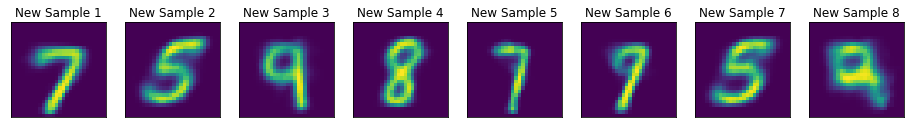

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 32], [train bce loss 13495.6173 +/- 473.2003], [train kld loss 646.8665 +/- 12.7379], [training time 8.01]
-------------------------------------------------------------------


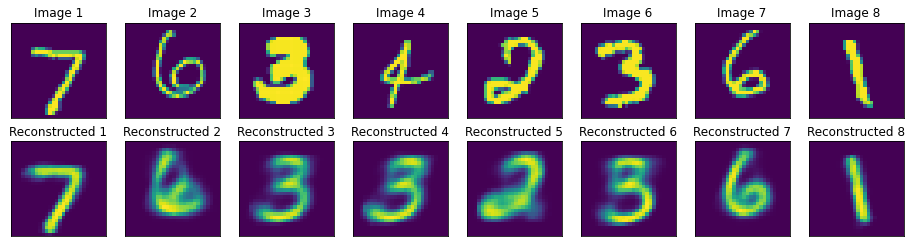

-------------------------------------------------------------------
[epoch 32], [test bce loss 13670.7531 +/- 799.0685], [test kld loss 636.5538 +/- 23.2204], [testing time 1.75]
-------------------------------------------------------------------


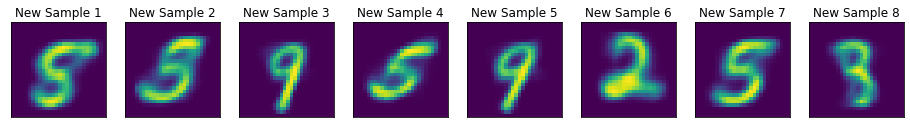

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 33], [train bce loss 13482.6193 +/- 463.3198], [train kld loss 648.0639 +/- 12.8095], [training time 7.93]
-------------------------------------------------------------------


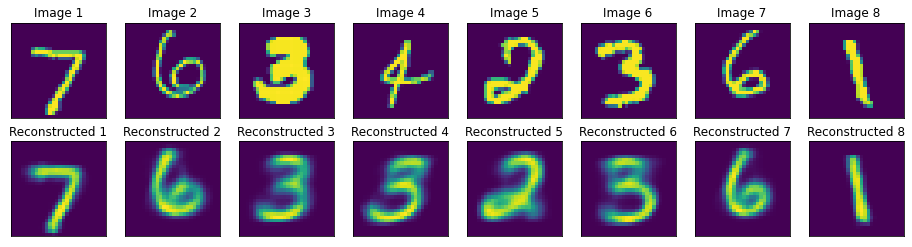

-------------------------------------------------------------------
[epoch 33], [test bce loss 13664.2040 +/- 864.7895], [test kld loss 639.1893 +/- 22.0957], [testing time 1.66]
-------------------------------------------------------------------


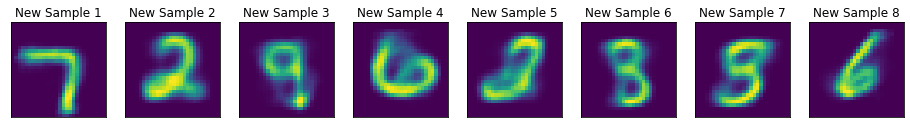

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 34], [train bce loss 13462.9587 +/- 479.2381], [train kld loss 649.3659 +/- 11.9499], [training time 8.04]
-------------------------------------------------------------------


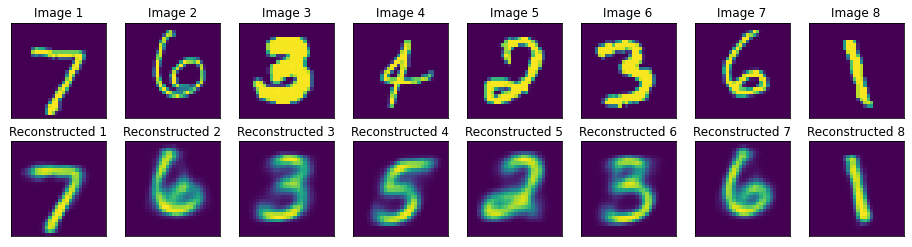

-------------------------------------------------------------------
[epoch 34], [test bce loss 13601.3800 +/- 842.6593], [test kld loss 652.8493 +/- 20.3366], [testing time 1.86]
-------------------------------------------------------------------


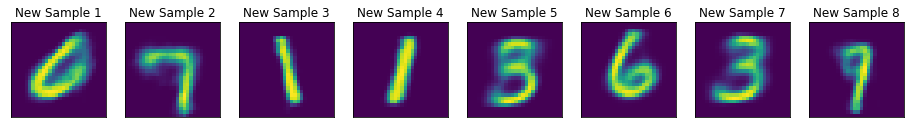

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 35], [train bce loss 13428.1373 +/- 459.8989], [train kld loss 650.1609 +/- 12.1114], [training time 8.06]
-------------------------------------------------------------------


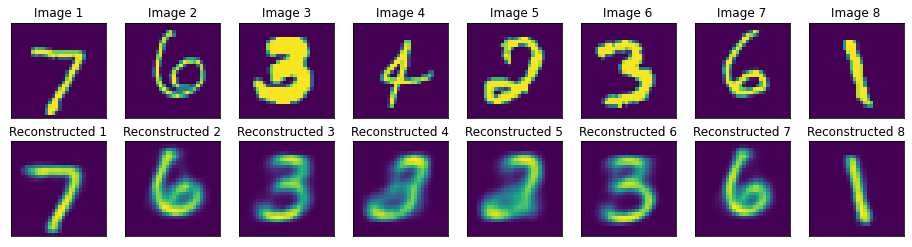

-------------------------------------------------------------------
[epoch 35], [test bce loss 13671.5111 +/- 866.5670], [test kld loss 635.7492 +/- 20.1016], [testing time 1.70]
-------------------------------------------------------------------


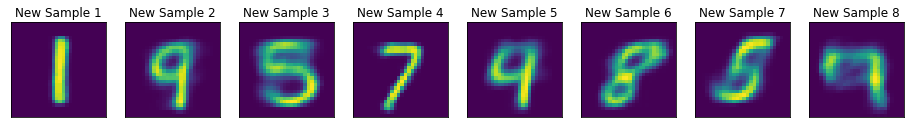

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 36], [train bce loss 13416.7961 +/- 491.1353], [train kld loss 651.4922 +/- 12.5169], [training time 8.07]
-------------------------------------------------------------------


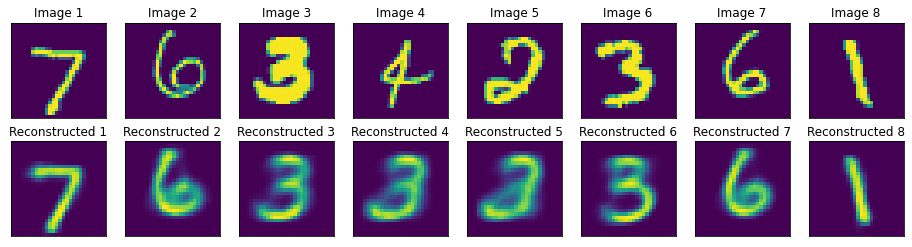

-------------------------------------------------------------------
[epoch 36], [test bce loss 13600.1191 +/- 849.6972], [test kld loss 654.8255 +/- 20.5436], [testing time 1.80]
-------------------------------------------------------------------


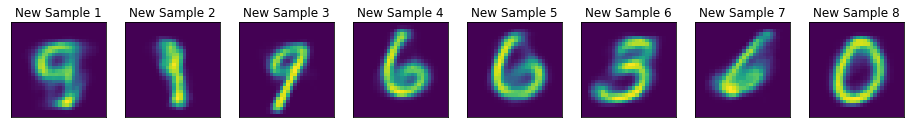

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 37], [train bce loss 13422.8878 +/- 461.8777], [train kld loss 653.4499 +/- 12.1939], [training time 8.04]
-------------------------------------------------------------------


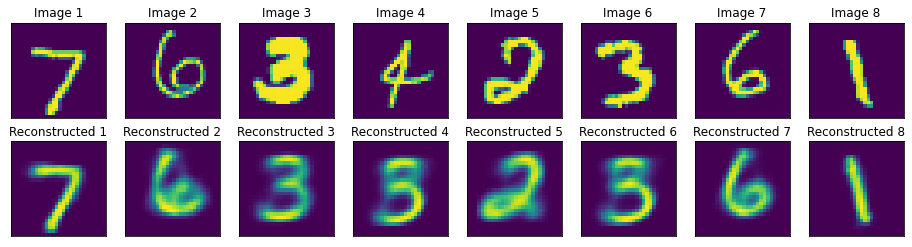

-------------------------------------------------------------------
[epoch 37], [test bce loss 13596.9908 +/- 795.2980], [test kld loss 640.3034 +/- 19.9089], [testing time 1.66]
-------------------------------------------------------------------


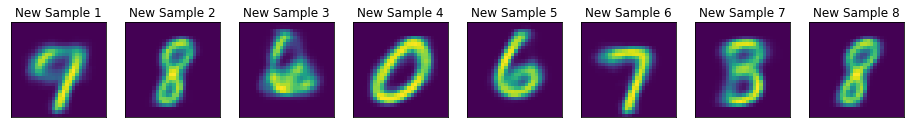

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 38], [train bce loss 13398.0585 +/- 452.2943], [train kld loss 654.1265 +/- 11.4568], [training time 8.65]
-------------------------------------------------------------------


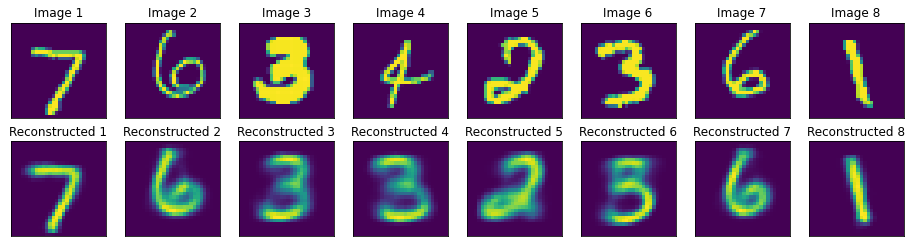

-------------------------------------------------------------------
[epoch 38], [test bce loss 13627.4119 +/- 882.6288], [test kld loss 655.4661 +/- 20.4552], [testing time 2.15]
-------------------------------------------------------------------


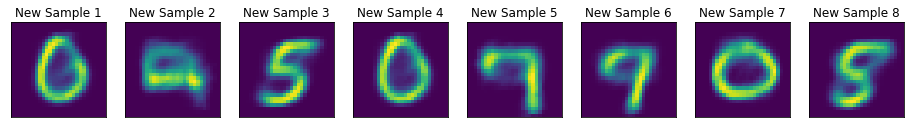

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 39], [train bce loss 13361.6575 +/- 472.3518], [train kld loss 655.2489 +/- 11.6424], [training time 8.23]
-------------------------------------------------------------------


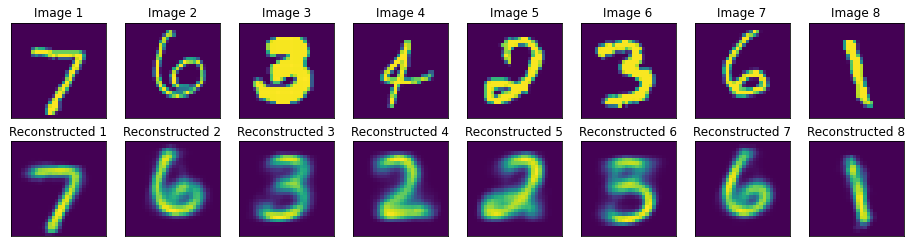

-------------------------------------------------------------------
[epoch 39], [test bce loss 13572.3299 +/- 819.7105], [test kld loss 656.3754 +/- 18.7776], [testing time 1.66]
-------------------------------------------------------------------


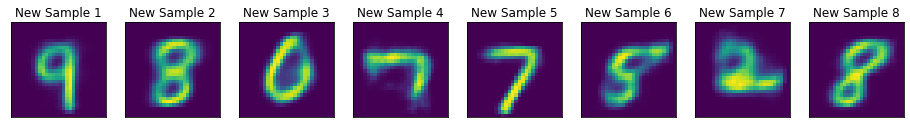

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 40], [train bce loss 13350.8107 +/- 471.5548], [train kld loss 657.4121 +/- 12.3473], [training time 8.14]
-------------------------------------------------------------------


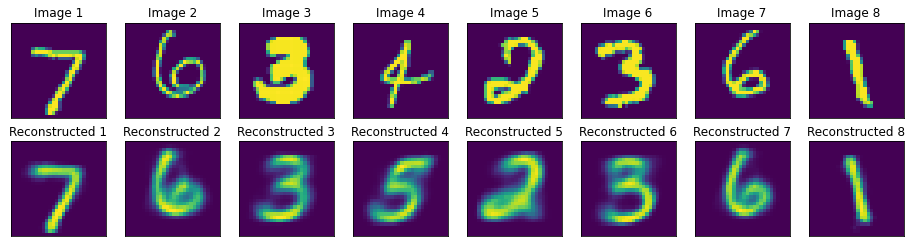

-------------------------------------------------------------------
[epoch 40], [test bce loss 13555.2818 +/- 803.9992], [test kld loss 648.1427 +/- 16.3301], [testing time 1.73]
-------------------------------------------------------------------


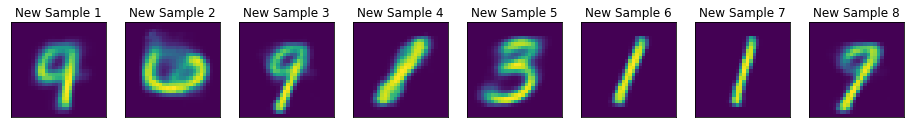

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 41], [train bce loss 13348.1717 +/- 474.9813], [train kld loss 657.3197 +/- 11.7192], [training time 8.25]
-------------------------------------------------------------------


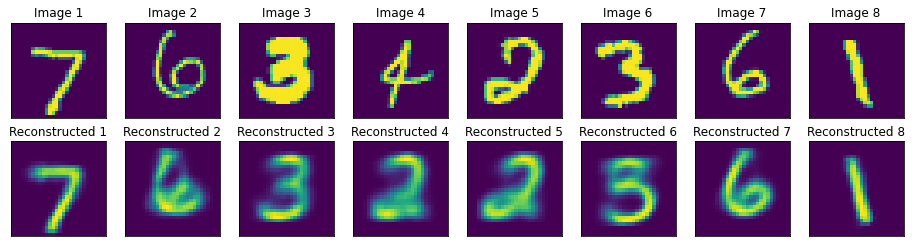

-------------------------------------------------------------------
[epoch 41], [test bce loss 13568.7763 +/- 823.7652], [test kld loss 642.1642 +/- 17.9466], [testing time 1.71]
-------------------------------------------------------------------


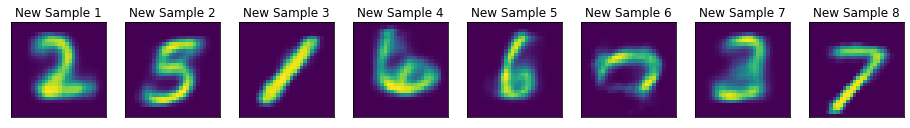

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 42], [train bce loss 13333.5125 +/- 461.0008], [train kld loss 658.7470 +/- 11.3212], [training time 8.23]
-------------------------------------------------------------------


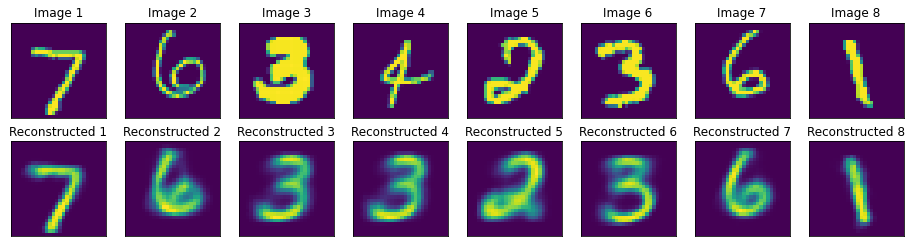

-------------------------------------------------------------------
[epoch 42], [test bce loss 13551.0674 +/- 815.2273], [test kld loss 655.4710 +/- 17.7143], [testing time 1.72]
-------------------------------------------------------------------


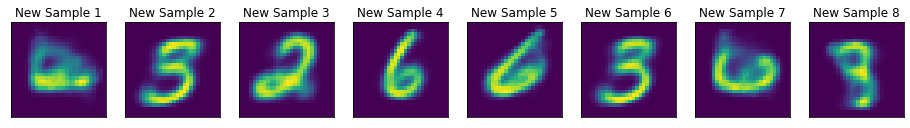

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 43], [train bce loss 13324.9080 +/- 485.5266], [train kld loss 656.8823 +/- 11.6796], [training time 8.16]
-------------------------------------------------------------------


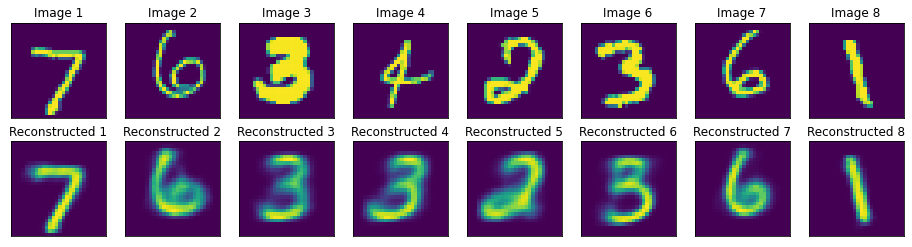

-------------------------------------------------------------------
[epoch 43], [test bce loss 13554.9635 +/- 818.3356], [test kld loss 643.4808 +/- 17.0885], [testing time 1.88]
-------------------------------------------------------------------


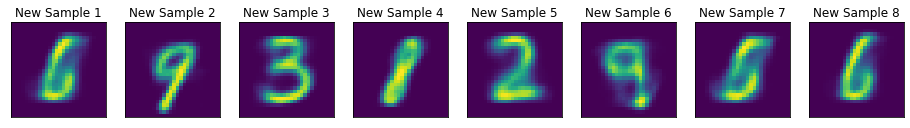

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 44], [train bce loss 13311.4226 +/- 472.3299], [train kld loss 657.7219 +/- 11.7871], [training time 8.20]
-------------------------------------------------------------------


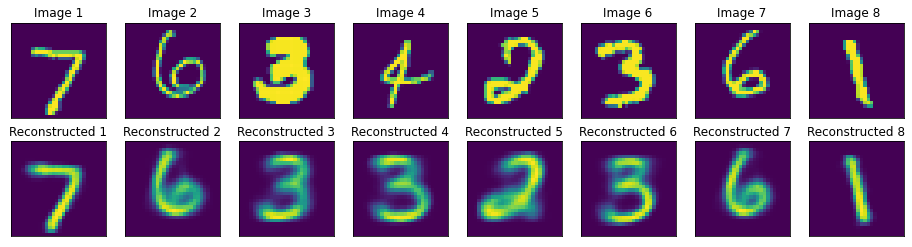

-------------------------------------------------------------------
[epoch 44], [test bce loss 13538.2034 +/- 843.3635], [test kld loss 655.6456 +/- 19.1491], [testing time 1.75]
-------------------------------------------------------------------


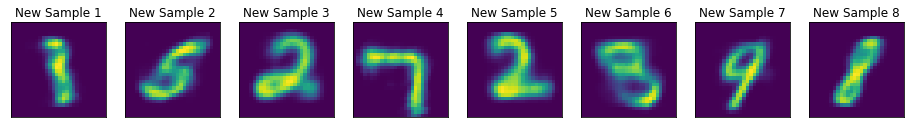

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 45], [train bce loss 13296.0762 +/- 465.7650], [train kld loss 659.7979 +/- 11.5884], [training time 8.17]
-------------------------------------------------------------------


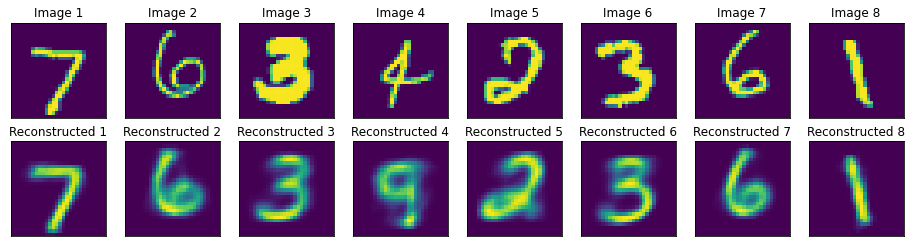

-------------------------------------------------------------------
[epoch 45], [test bce loss 13531.7754 +/- 839.0365], [test kld loss 661.9466 +/- 21.6224], [testing time 1.86]
-------------------------------------------------------------------


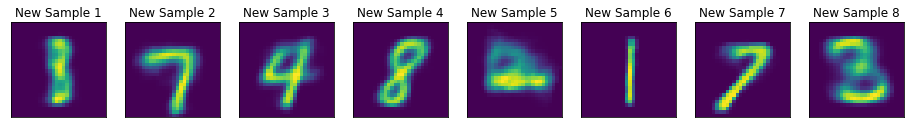

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 46], [train bce loss 13298.2912 +/- 464.2278], [train kld loss 660.6098 +/- 11.4232], [training time 8.27]
-------------------------------------------------------------------


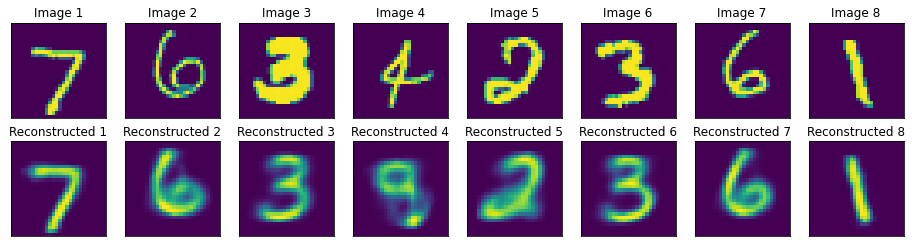

-------------------------------------------------------------------
[epoch 46], [test bce loss 13475.0996 +/- 801.4855], [test kld loss 665.9499 +/- 18.0180], [testing time 1.70]
-------------------------------------------------------------------


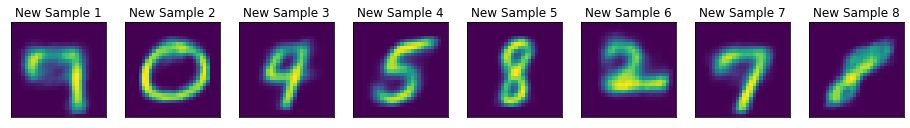

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 47], [train bce loss 13286.6202 +/- 450.7157], [train kld loss 660.6676 +/- 11.6172], [training time 8.14]
-------------------------------------------------------------------


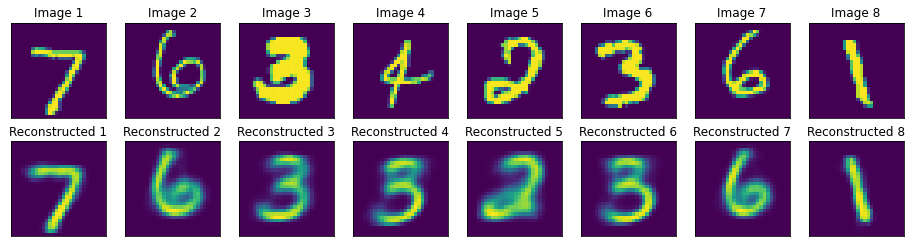

-------------------------------------------------------------------
[epoch 47], [test bce loss 13500.1224 +/- 814.0371], [test kld loss 661.3518 +/- 19.5566], [testing time 1.83]
-------------------------------------------------------------------


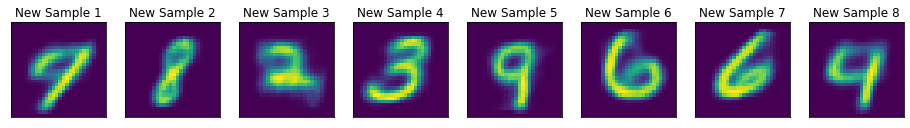

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 48], [train bce loss 13266.4891 +/- 473.4282], [train kld loss 662.3633 +/- 12.0509], [training time 8.02]
-------------------------------------------------------------------


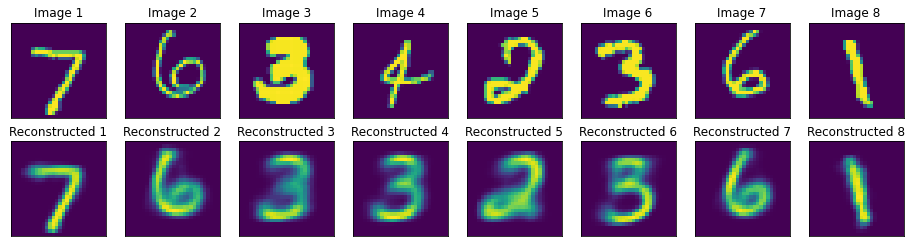

-------------------------------------------------------------------
[epoch 48], [test bce loss 13489.7574 +/- 840.9187], [test kld loss 648.3370 +/- 20.2906], [testing time 1.70]
-------------------------------------------------------------------


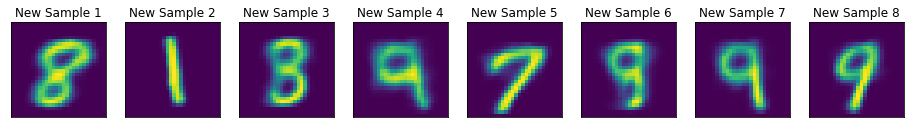

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 49], [train bce loss 13235.6759 +/- 469.5021], [train kld loss 663.1128 +/- 11.6138], [training time 8.57]
-------------------------------------------------------------------


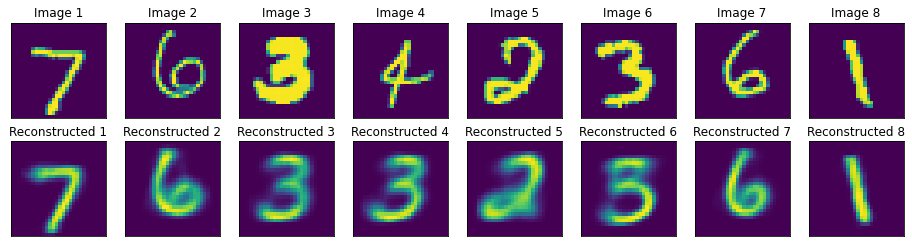

-------------------------------------------------------------------
[epoch 49], [test bce loss 13492.0662 +/- 849.1427], [test kld loss 664.8703 +/- 19.6506], [testing time 2.16]
-------------------------------------------------------------------


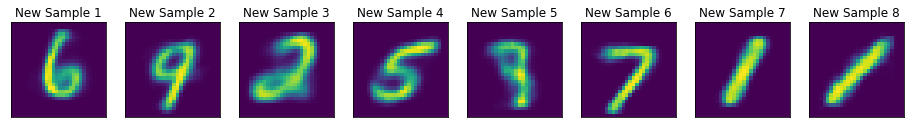

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 50], [train bce loss 13223.3600 +/- 481.7476], [train kld loss 665.5231 +/- 10.9480], [training time 8.16]
-------------------------------------------------------------------


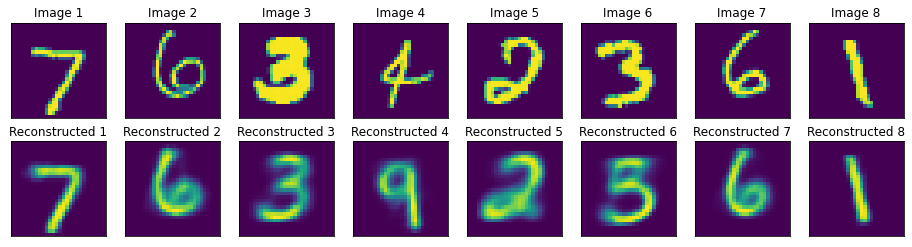

-------------------------------------------------------------------
[epoch 50], [test bce loss 13495.5718 +/- 828.3750], [test kld loss 652.0192 +/- 18.4835], [testing time 1.73]
-------------------------------------------------------------------


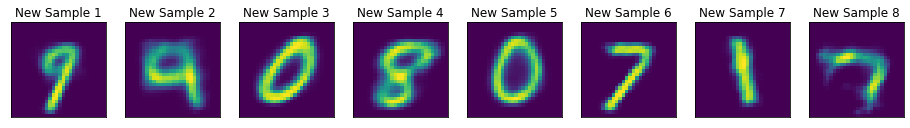

-- End of Epoch ---------------------------------------------------
-------------------------------------------------------------------


In [10]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, epoch)
    
    # Evaluating sample generation in VAE.
    evaluate(net, args['num_samples'], args['num_gauss'])
    
    print('-- End of Epoch ---------------------------------------------------')
    print('-------------------------------------------------------------------')

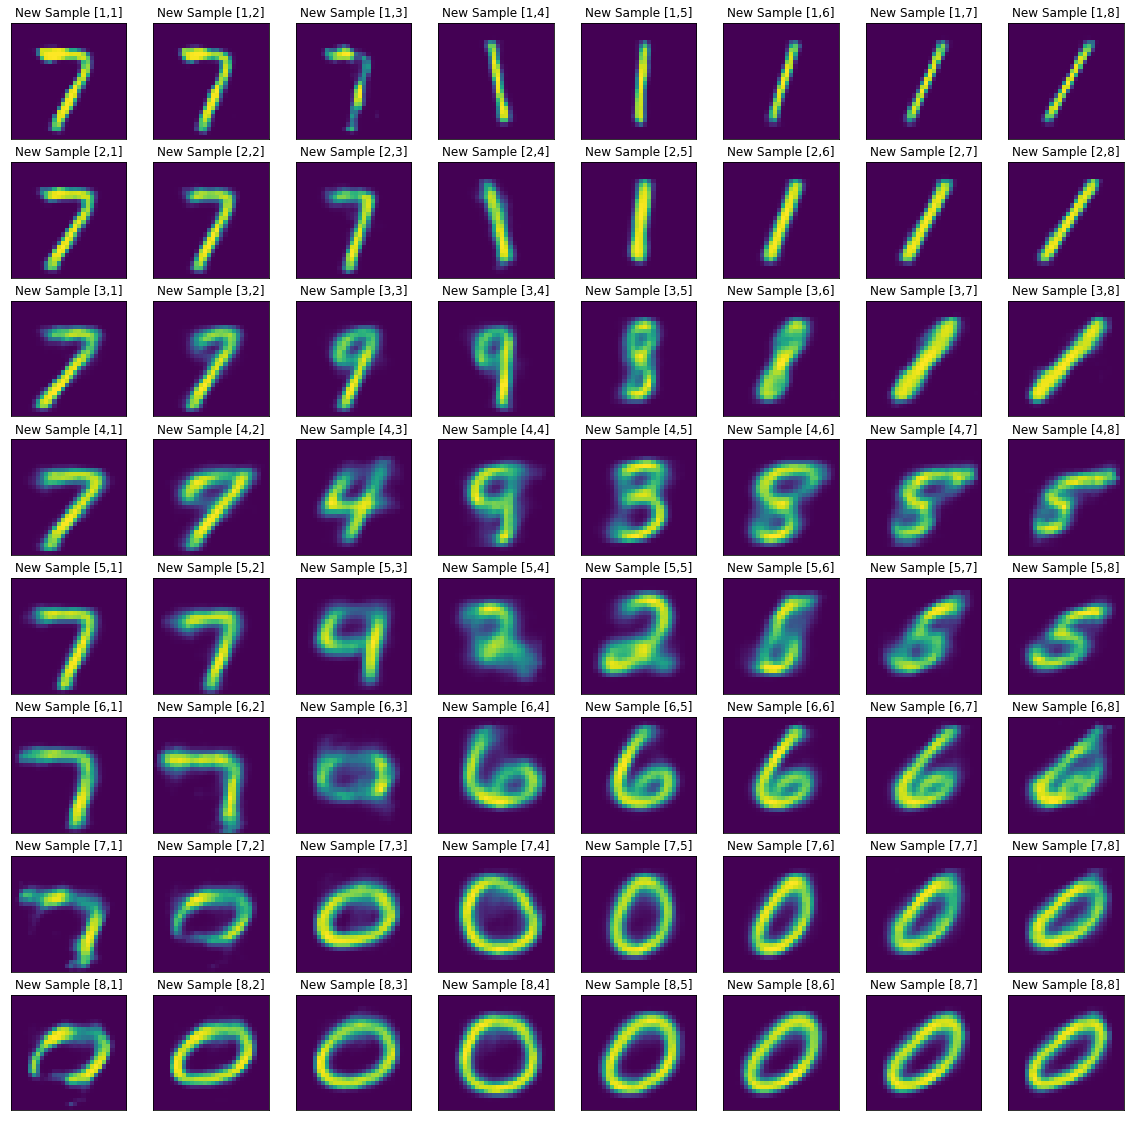

In [11]:
# Evaluation procedure for sample generation.
def generate_2d(net, n_samples, n_gauss):

    # Setting network for evaluation mode.
    net.eval()
    
    # Creating linear space to visualize bivariate gaussian.
    linspace_gauss = torch.linspace(-2.5, 2.5, n_samples)
    
    # Select Gaussian dimensions
    dim_linspace = (0, 1)
    
    # Plotting.
    fig, ax = plt.subplots(n_samples, n_samples, figsize=(20, 20))

    for i in range(n_samples):
        
        for j in range(n_samples):

            # Filling batch with size 1 and n_gauss zeros of dimension.
            sample = torch.zeros(1, n_gauss).to(args['device'])
            
            # Replacing zeros in dimensions dim_linspace with values from
            # variable linspace_gauss.
            sample[0, dim_linspace[0]] = linspace_gauss[j]
            sample[0, dim_linspace[1]] = linspace_gauss[i]

            # Forwarding through decoder.
            sample = net.decode(sample).detach().cpu().view(28, 28).numpy()

            # Printing sample.
            ax[j, i].imshow(sample)
            ax[j, i].set_yticks([])
            ax[j, i].set_xticks([])
            ax[j, i].set_title('New Sample [' + str(j + 1) + ',' + str(i + 1) + ']')
        
    plt.show()
    
    
generate_2d(net, args['num_samples'], args['num_gauss'])